# Imports and project setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict
import math

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "xx-large"
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

## Function definitions

In [3]:
def delta_to_phi(delta):
    return 1.2 - delta*0.2

def make_axes_label(ax, label, pos=(0.0, 1.05), fontsize=None):
    ax.text(*pos, label, fontsize=fontsize, transform=ax.transAxes)

In [4]:
def compute_unwrapped_pos_from_deltas(traj):
    ref_snap = traj[0]
    ref_pos = ref_snap.particles.position.copy()
    box = freud.box.Box.from_box(ref_snap.configuration.box)
    pos_shape = ref_pos.shape
    pos = np.zeros((len(traj), *pos_shape), dtype=np.float32)
    pos[0] = ref_pos
    for i, snap in enumerate(traj[1:]):
        next_pos = snap.particles.position.copy()
        pos[i+1] = box.wrap(next_pos - ref_pos) + pos[i]
        ref_pos = next_pos

    return pos

def extract_relative_timesteps(traj):
    
    tsteps = np.zeros(len(traj))
    tstep0 = traj[0].log['Simulation/timestep'][0]
    for i in range(len(traj)):
        tsteps[i] = traj[i].log['Simulation/timestep'][0] - tstep0

    return tsteps


def sisf(pos, k=7.14):

    term = k*np.linalg.norm(pos - pos[0], axis=-1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.mean(np.nan_to_num(np.sin(term)/term, nan=1.0), axis=1)



def is_file_older_than(file, cutoff):
    mtime = datetime.utcfromtimestamp(os.path.getmtime(file))
    if mtime < cutoff:
        return True
    return False


In [5]:
def digitize_mask(x, mu_min, mu_max, bins):
    digs = np.floor((x - mu_min) / (mu_max - mu_min) * bins).astype(np.int32)
    return np.ma.masked_array(digs, mask=(digs < 0) | (digs >= bins))


def digitize_in_bounds(x, mu_min, mu_max, bins):
    digs = digitize_mask(x, mu_min, mu_max, bins)
    return digs[~digs.mask].data


def bin_linspaced_data(x, mu_min, mu_max, bins):
    digs = digitize_in_bounds(x, mu_min, mu_max, bins)
    return np.bincount(digs, minlength=bins)


def pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi):
    dr = r[1] - r[0]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return -2.0*np.pi*phi*f_a*np.sum(np.nan_to_num(g_a*np.log(g_a) - g_a + 1)*r*r)*dr \
                + -2.0*np.pi*phi*f_b*np.sum(np.nan_to_num(g_b*np.log(g_b) - g_b + 1)*r*r)*dr

In [6]:
@njit
def excess_entropy(r, g, dr):
    prelim = (g*np.log(g)-g+1)*r*r*dr
    prelim[np.isnan(prelim)] = 0
    return -2.0*np.pi*np.sum(prelim)

@njit
def local_excess_entropy(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)
    return out


@njit
def local_excess_entropy_binary(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr)
    return out

In [7]:
@njit
def local_excess_entropy_density(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)/vol/inv_n
    return out


@njit
def local_excess_entropy_binary_density(r, sfs, dr):
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = (na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out
@njit
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

@njit
def local_excess_entropy_binary_density_var(r, sfs, dr, alpha=0.5, taper=(2.0, 1.0)):
    if not (alpha <= 1.0 and alpha >= 0.0):
        raise ValueError("alpha must be between 0 and 1")
    alpha_n = 1 - alpha
    vol = 4/3*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    log_taper = sigmoid((r - taper[0])/taper[1])
    nlt = 1 - log_taper
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol*nlt + log_taper
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol*nlt + log_taper
        out[i] = (alpha*na/n*excess_entropy(r, g_a, dr) + alpha_n*nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out


@njit
def local_excess_entropy_binary_density_var_exp(r, sfs, dr, alpha=0.5, taper=(2.0, 0.1), end=-1):
    if not (alpha <= 1.0 and alpha >= 0.0):
        raise ValueError("alpha must be between 0 and 1")
    alpha_n = 1 - alpha
    vol = 4/3*np.pi*(r[end]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    log_taper = sigmoid((r - taper[0])/taper[1])
    nlt = 1 - log_taper
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2][:end])
        nb = np.sum(sfs[i,1::2][:end])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol*nlt + log_taper
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol*nlt + log_taper
        out[i] = (alpha*na/n*excess_entropy(r, g_a, dr) + alpha_n*nb/n*excess_entropy(r, g_b, dr))*n/vol
    return out

# Figure 5 - Group particle by softness and map softness to binary excess entropy

In [7]:
r_be = np.linspace(0.1, 5.0, 246)
r_bc = r_be[:-1] + np.diff(r_be)/2
# r_bc

In [57]:
def _default_array():
    return np.zeros_like(r_bc)


for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    phi = delta_to_phi(delta)
    for (traj_idx, frame), tdf in 

    jobs = list(jobs_iter)

    job0 = jobs[0]
    temps = job0.doc["temps"]

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    bounds_file = project.fn(f"structure/softness-bounds_delta-{delta}.pickle")
    if os.path.exists(bounds_file):
        softness_bounds = pickle.load(open(bounds_file, "rb"))
    else:
        raise Exception("No bounds file")

    plot_data = []

    be = np.linspace(softness_bounds["min"], softness_bounds["max"], 11)
    soft_bin_centers = be[:-1] + np.diff(be)/2

    rearrang_file = project.fn(f"prob_rearrang/rdfs-bin-softness-less3_delta-{delta}.pickle")
    
    itemps = []
    rearrang_data = []
    for temp in sorted(temps[:-2]):
        itemps.append(1/temp)
        print(temp)
        trajs = []
        dfs = []
        for idx, job in enumerate(jobs):
            files = glob.glob(job.fn(f"short_runs/temp-{temp:.2f}/sfs.parquet"))
            if len(files) == 0:
                raise Exception("No files")
            assert len(files) == 1
            file = files[0]
            traj = file.replace("sfs.parquet", "traj.gsd")
            trajs.append(gsd.hoomd.open(traj))
            df = pd.read_parquet(file)
            df = df[df["type"] == 0]
            df["traj_idx"] = idx
            dfs.append(df)
        df = pd.concat(dfs)

        df["softness"] = pipe.decision_function(list(df["sf"]))
        df.drop("sf", axis=1, inplace=True)

        df["rearrang"] = df["phop"] > 0.2

        df["cuts"] = pd.cut(df["softness"], bins=be)

        data = []
        cuts = []
        Ns = []

        for cut, df_cut in df.groupby("cuts"):
            cuts.append(cut.mid)
            data.append(df_cut["rearrang"].mean())
            Ns.append(len(df_cut))
        data.append(data)

        rdf_a = defaultdict(_default_array)
        rdf_b = defaultdict(_default_array)

        vol = 4/3*np.pi*r_be[-1]**3
        shells = 4*np.pi*r_bc**2*(r_be[1] - r_be[0])

        for (traj_idx, frame), tdf in df.groupby(["traj_idx", "frame"]):
            # print(frame)
            snap: gsd.hoomd.Snapshot = trajs[traj_idx][int(frame)]
            box = freud.box.Box.from_box(snap.configuration.box)
            pos = snap.particles.position
            pos_a = pos[snap.particles.typeid == 0]
            pos_b = pos[snap.particles.typeid == 1]
            nlist_query_a = freud.locality.AABBQuery.from_system((box, pos_a))
            nlist_query_b = freud.locality.AABBQuery.from_system((box, pos_b))
            
            for soft, ttdf in tdf.groupby("cuts"):
                id = ttdf["tag"].to_numpy()
                nlist_a = nlist_query_a.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                nlist_b = nlist_query_b.query(pos[id], dict(r_max=5.0, r_min=0.1)).toNeighborList()
                rdf_a[float(soft.mid)] += bin_linspaced_data(nlist_a.distances, r_be[0], r_be[-1], len(r_be)-1)
                rdf_b[float(soft.mid)] += bin_linspaced_data(nlist_b.distances, r_be[0], r_be[-1], len(r_be)-1)
            del snap

        final_data = {}
        final_data["rdfs"] = {}
        
        for c in cuts:
            rdf = rdf_a[c]
            g_a = rdf/shells/np.sum(rdf)*vol
            rdf = rdf_b[c]
            g_b = rdf/shells/np.sum(rdf)*vol
            final_data["rdfs"][c] = dict(g_a=g_a, g_b=g_b)

        final_data["cuts"] = cuts
        final_data["rearrang"] = data
        final_data["Ns"] = Ns

        rearrang_data.append(final_data)
    
    pickle_data = dict(inv_t=itemps, data=rearrang_data, r_bc=r_bc, r_be=r_be, phi=phi, cuts=soft_bin_centers)
    pickle.dump(pickle_data, open(rearrang_file, "wb"))


0.0
0.45
0.47
0.49
0.51
0.53
0.55
0.58
0.61
0.64
0.67
0.7
0.75
0.8
0.9
1.0
1.2
1.4
1.6
1.8
2.0
0.1
0.56
0.59
0.61
0.64
0.67
0.69
0.73
0.77
0.8
0.84
0.88
0.94
1.0
1.13
1.25
1.51
1.76
2.01
2.26
2.51
0.2
0.73
0.76
0.8
0.83
0.86
0.89
0.94
0.99
1.04
1.09
1.14
1.22
1.3
1.46
1.63
1.95
2.28
2.6
2.93
3.25
0.3
0.99
1.03
1.08
1.12
1.16
1.21
1.27
1.34
1.41
1.47
1.54
1.65
1.76
1.98
2.2
2.64
3.08
3.51
3.95
4.39
0.4
1.42
1.48
1.54
1.6
1.67
1.73
1.82
1.92
2.01
2.11
2.2
2.36
2.52
2.83
3.15
3.77
4.4
5.03
5.66
6.29


In [56]:
for cut, df_cut in df.groupby("cuts"):
    print(cut, len(df_cut))

(-0.769, -0.63] 29857
(-0.63, -0.492] 44348
(-0.492, -0.353] 59468
(-0.353, -0.215] 72108
(-0.215, -0.076] 80541
(-0.076, 0.0626] 82620
(0.0626, 0.201] 77567
(0.201, 0.34] 66899
(0.34, 0.478] 53279
(0.478, 0.617] 39496


2.23200724992835 [1.42 1.48 1.54 1.6  1.67 1.73 1.82 1.92 2.01 2.11 2.2  2.36 2.52 2.83
 3.15 3.77 4.4  5.03 5.66 6.29]


Text(0, 0.5, '$\\frac{\\Sigma \\cdot T_a}{- \\Delta F(T_a)} \\cdot \\frac{T_a}{T}$')

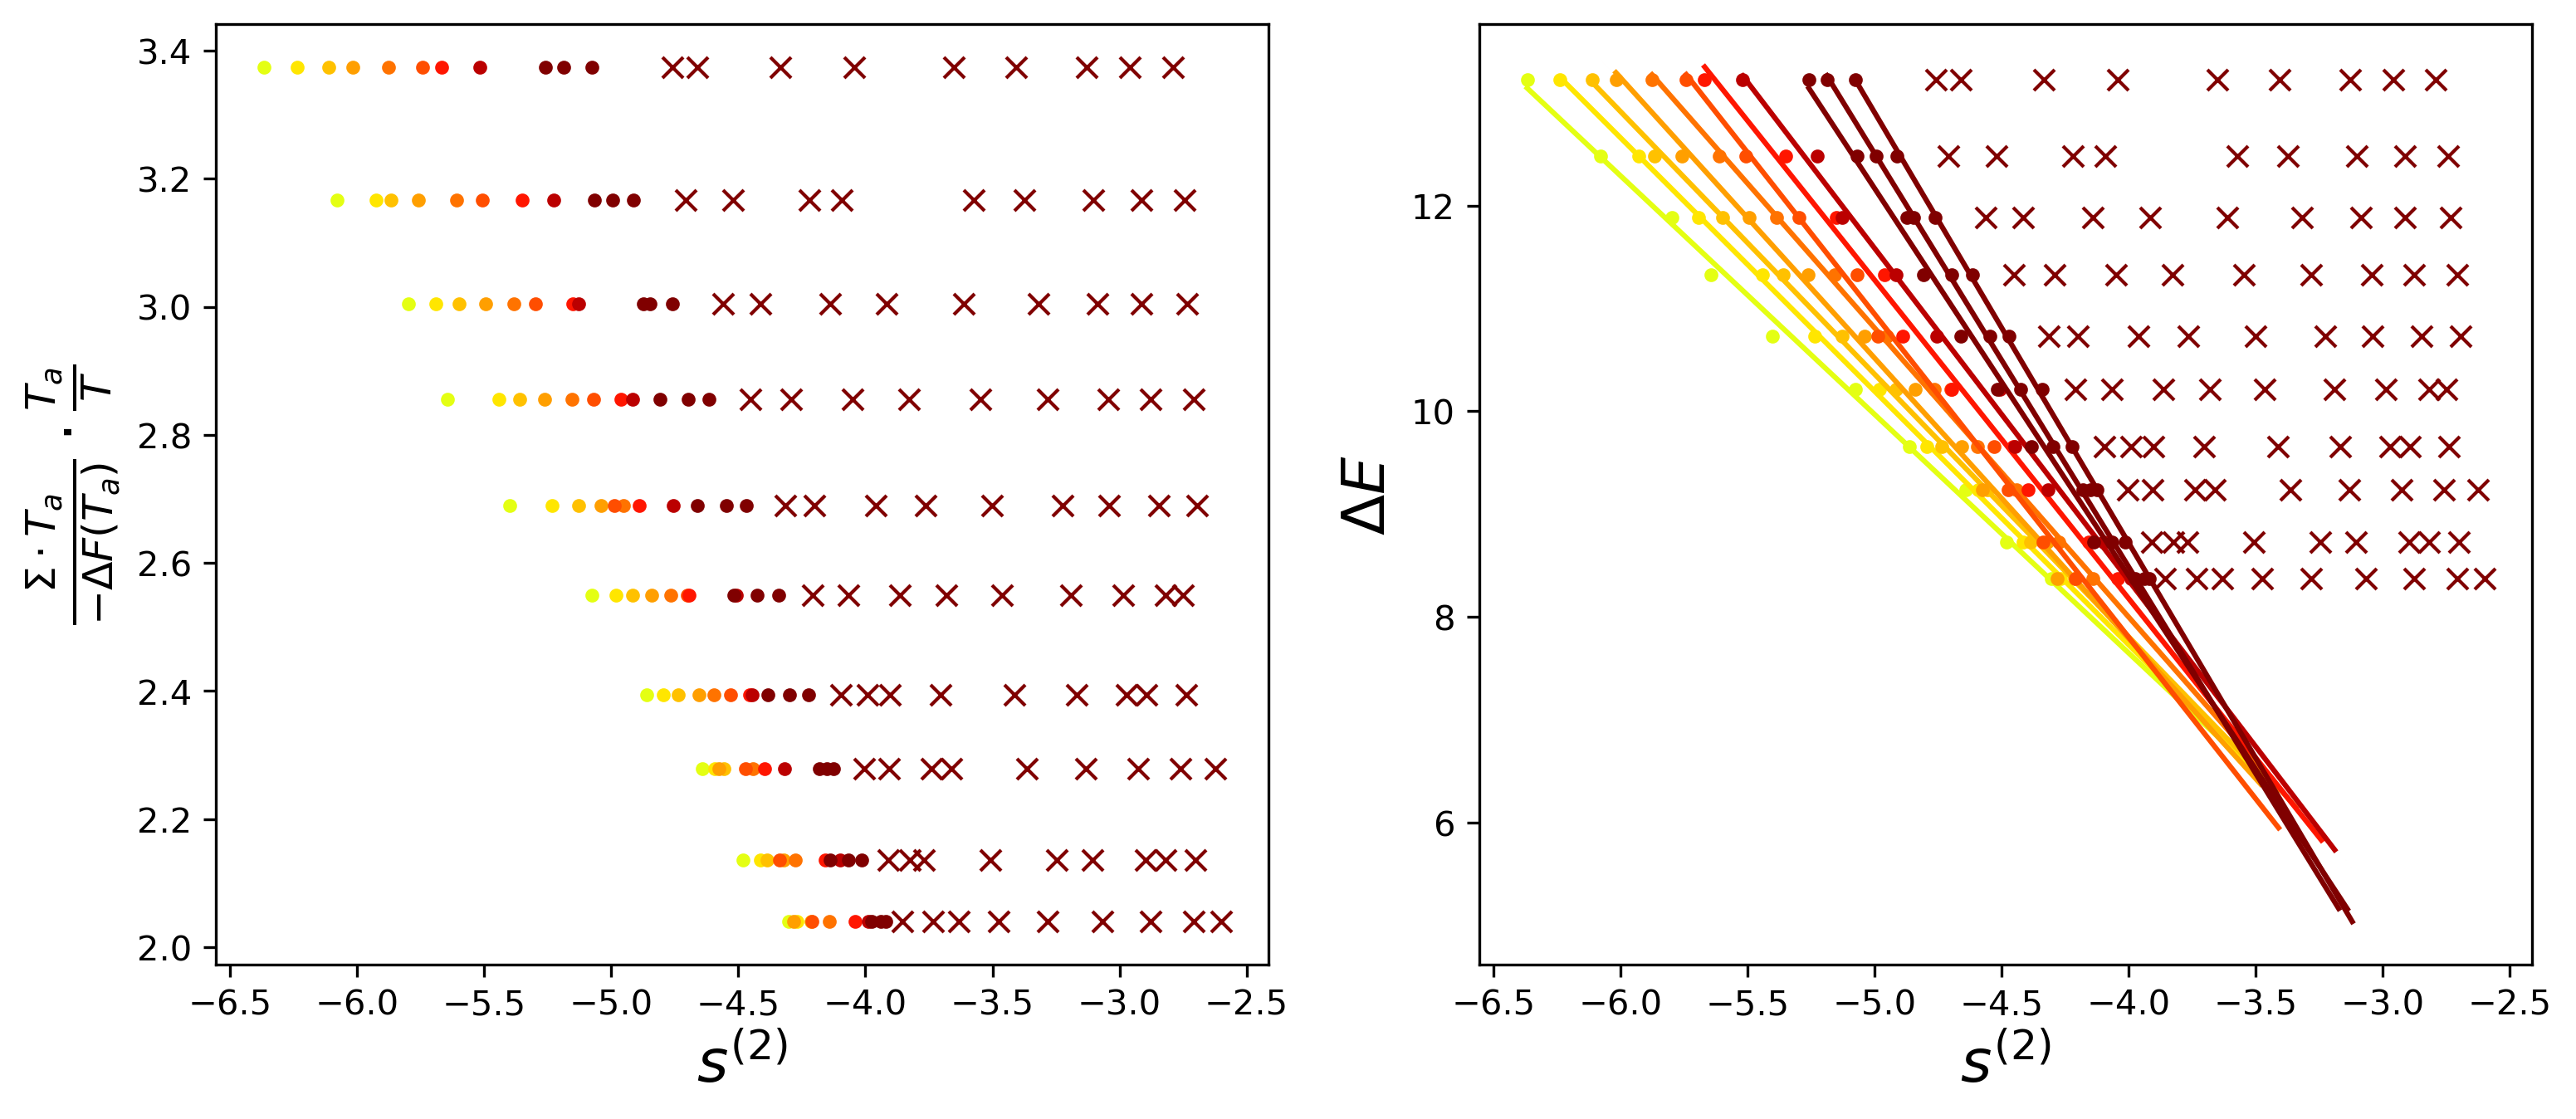

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
cmap = cm.jet
norm = colors.Normalize(0.45, 2.0)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-less2_delta-{delta}.pickle")

    if delta != 0.4:
        continue

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    da_temps = 1/np.array(itemps)
    
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(T_a, da_temps)
    

    for j in range(len(itemps)):
        real_temp = 1/itemps[j]
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        fits = np.array(fits)
        entropy = np.array(entropy)

        m = "."
        if real_temp > T_a:
            m = "x"
        else:
            idx = np.isfinite(entropy) & np.isfinite(-fits[:,0])
            a = np.polyfit(entropy[idx], -fits[idx,0], 1)
            x = np.linspace(entropy.min(), entropy.max()+.8, 100)
            y = np.polyval(a, x)
            axs[1].plot(x, y, "-", color=cmap(norm(real_temp)))

        axs[0].plot(entropy, fits[:,1], m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(real_temp)))
        
        axs[1].plot(entropy, -fits[:,0], m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(real_temp)))

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[1].set_ylabel(r"$\Delta E$", size="xx-large")
# plt.sca(axs[0])
# plt.legend(title=r"$\Delta$")

axs[1].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$\frac{\Sigma \cdot T_a}{- \Delta F(T_a)} \cdot \frac{T_a}{T}$", size="xx-large")

2.23200724992835 [1.42 1.48 1.54 1.6  1.67 1.73 1.82 1.92 2.01 2.11 2.2  2.36 2.52 2.83
 3.15 3.77 4.4  5.03 5.66 6.29]


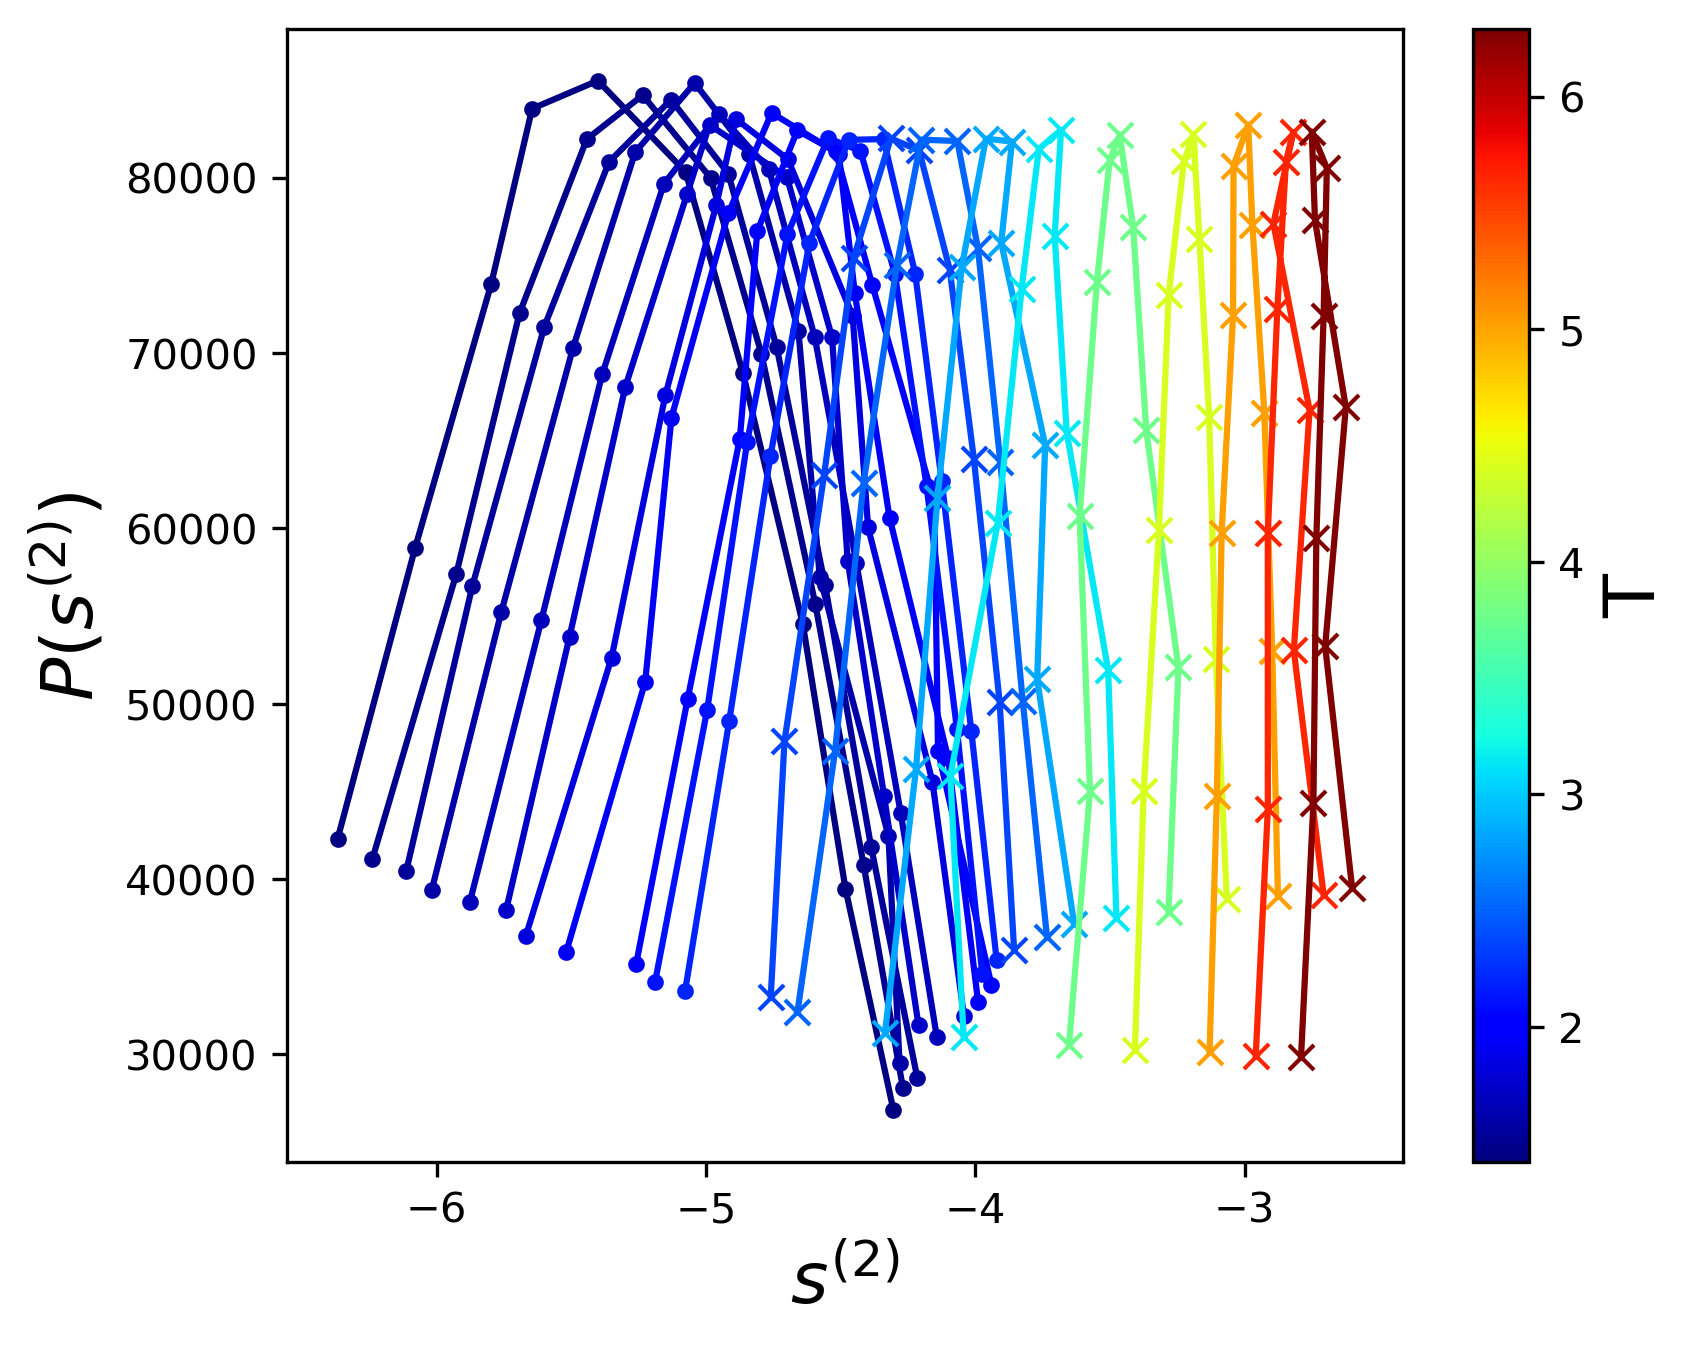

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

axs = [axs]

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-less3_delta-{delta}.pickle")

    if delta != 0.4:
        continue

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    da_temps = 1/np.array(itemps)
    
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(T_a, da_temps)

    cmap = cm.jet
    norm = colors.Normalize(da_temps.min(), da_temps.max())

    for j in range(len(itemps)):
        real_temp = 1/itemps[j]
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        fits = np.array(fits)
        entropy = np.array(entropy)

        m = "."
        if real_temp > T_a:
            m = "x"

        Ns = np.array(data["data"][j]["Ns"])

        axs[0].plot(entropy, Ns, m, linestyle="-", label=f"{delta:.1f}", color=cmap(norm(real_temp)))
        

axs[0].set_xlabel(r"$s^{(2)}$", size="xx-large")
axs[0].set_ylabel(r"$P(s^{(2)})$", size="xx-large")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], label="T")

0.716854578685853 [0.45 0.47 0.49 0.51 0.53 0.55 0.58 0.61 0.64 0.67 0.7  0.75 0.8  0.9
 1.   1.2  1.4  1.6  1.8  2.  ]
0.8798073052271798 [0.56 0.59 0.61 0.64 0.67 0.69 0.73 0.77 0.8  0.84 0.88 0.94 1.   1.13
 1.25 1.51 1.76 2.01 2.26 2.51]
1.1361484261693002 [0.73 0.76 0.8  0.83 0.86 0.89 0.94 0.99 1.04 1.09 1.14 1.22 1.3  1.46
 1.63 1.95 2.28 2.6  2.93 3.25]
1.5648003186178345 [0.99 1.03 1.08 1.12 1.16 1.21 1.27 1.34 1.41 1.47 1.54 1.65 1.76 1.98
 2.2  2.64 3.08 3.51 3.95 4.39]


/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_203474/968518908.py:68: RuntimeWarning: 

2.23200724992835 [1.42 1.48 1.54 1.6  1.67 1.73 1.82 1.92 2.01 2.11 2.2  2.36 2.52 2.83
 3.15 3.77 4.4  5.03 5.66 6.29]


Text(0, 0.5, '$std(s^{(2)})$')

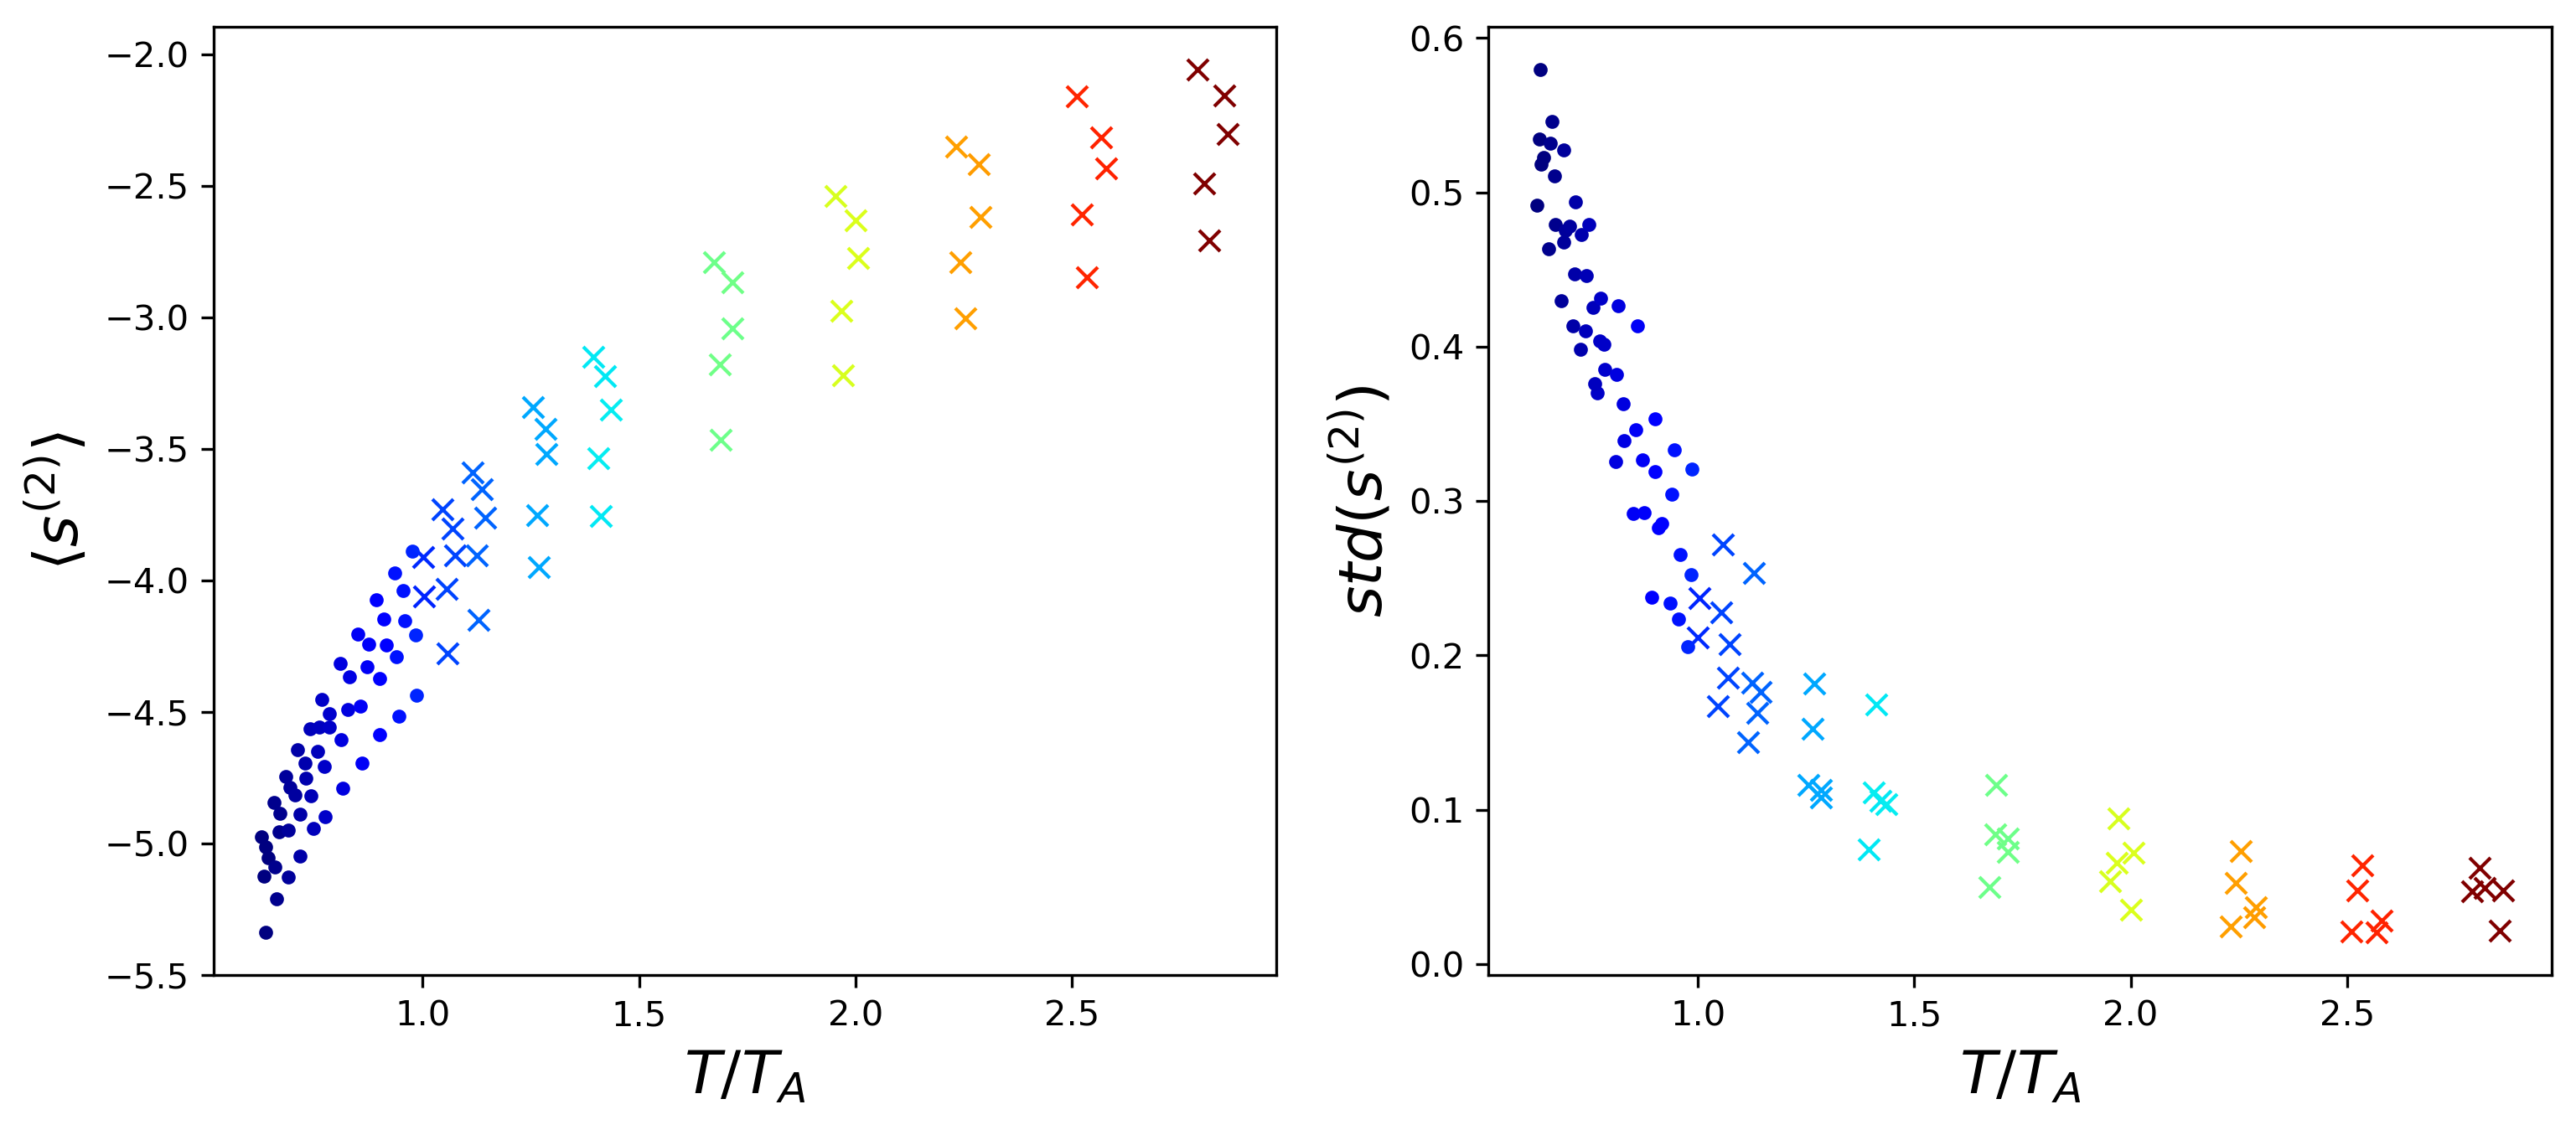

In [22]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-less3_delta-{delta}.pickle")

    # if delta != 0.4:
    #     continue

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    da_temps = 1/np.array(itemps)
    
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(T_a, da_temps)

    cmap = cm.jet
    norm = colors.Normalize(da_temps.min(), da_temps.max())

    for j in range(len(itemps)):
        real_temp = 1/itemps[j]
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        fits = np.array(fits)
        entropy = np.array(entropy)

        m = "."
        if real_temp > T_a:
            m = "x"

        Ns = np.array(data["data"][j]["Ns"])

        avg, std = weighted_avg_and_std(entropy, Ns)

        axs[0].plot(real_temp/T_a, avg, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(real_temp)))
        axs[1].plot(real_temp/T_a, std, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(real_temp)))
        

axs[0].set_xlabel(r"$T/T_A$", size="xx-large")
axs[0].set_ylabel(r"$\langle s^{(2)} \rangle$", size="xx-large")
axs[1].set_xlabel(r"$T/T_A$", size="xx-large")
axs[1].set_ylabel(r"$std(s^{(2)})$", size="xx-large")

0.716854578685853 [0.45 0.47 0.49 0.51 0.53 0.55 0.58 0.61 0.64 0.67 0.7  0.75 0.8  0.9
 1.   1.2  1.4  1.6  1.8  2.  ]
0.8798073052271798 [0.56 0.59 0.61 0.64 0.67 0.69 0.73 0.77 0.8  0.84 0.88 0.94 1.   1.13
 1.25 1.51 1.76 2.01 2.26 2.51]
1.1361484261693002 [0.73 0.76 0.8  0.83 0.86 0.89 0.94 0.99 1.04 1.09 1.14 1.22 1.3  1.46
 1.63 1.95 2.28 2.6  2.93 3.25]


/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2689710709.py:68: RuntimeW

1.5648003186178345 [0.99 1.03 1.08 1.12 1.16 1.21 1.27 1.34 1.41 1.47 1.54 1.65 1.76 1.98
 2.2  2.64 3.08 3.51 3.95 4.39]
2.23200724992835 [1.42 1.48 1.54 1.6  1.67 1.73 1.82 1.92 2.01 2.11 2.2  2.36 2.52 2.83
 3.15 3.77 4.4  5.03 5.66 6.29]


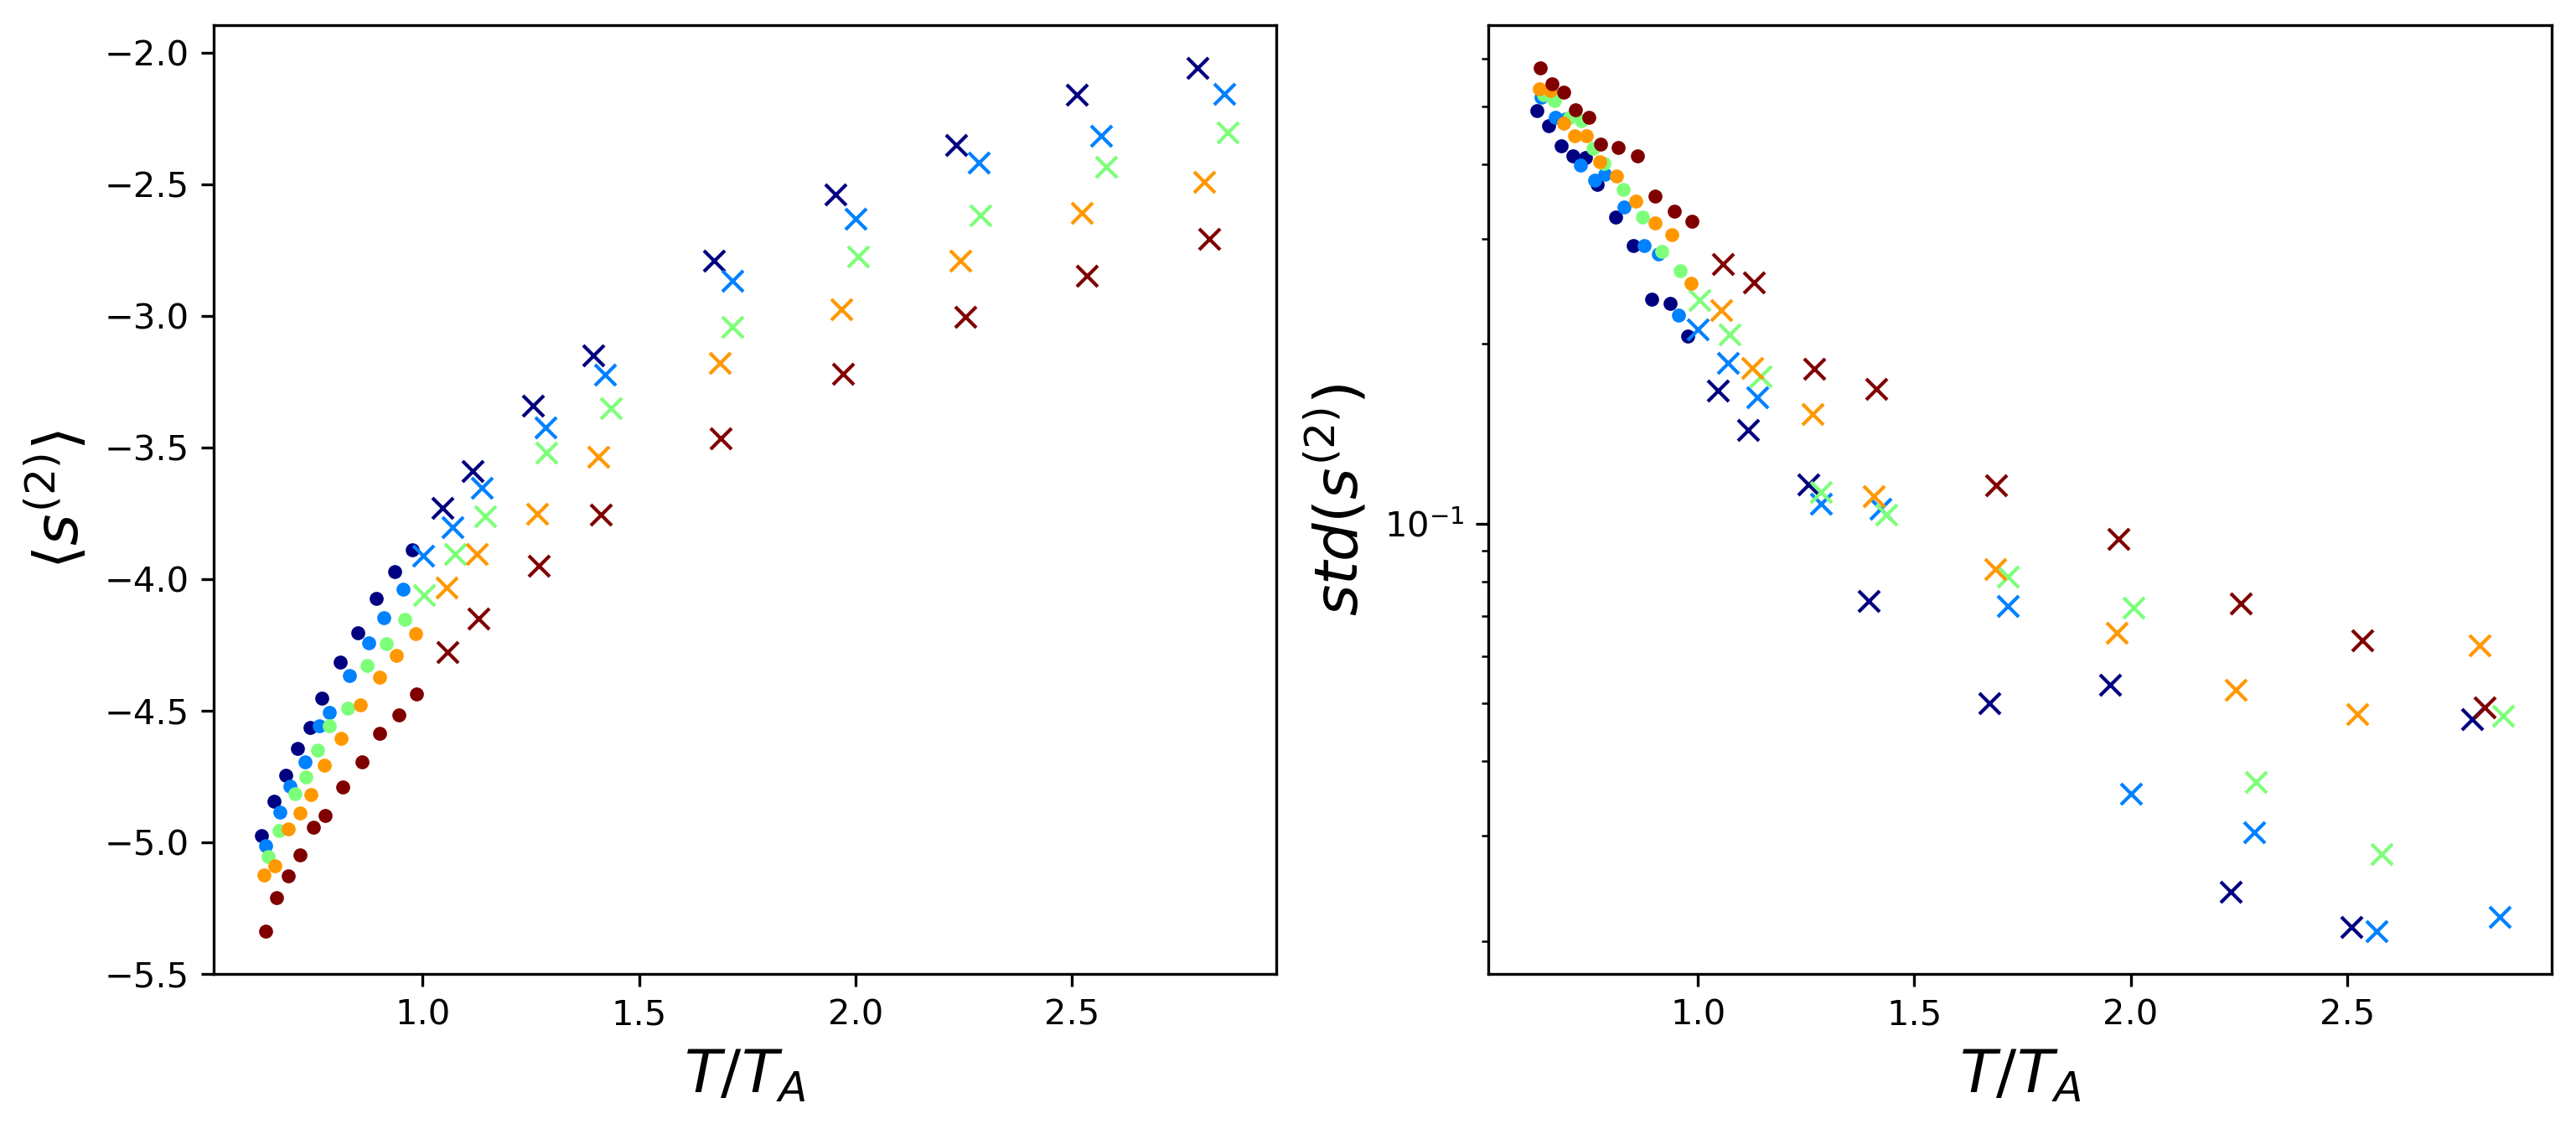

In [16]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=150)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-less3_delta-{delta}.pickle")

    # if delta != 0.4:
    #     continue

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    da_temps = 1/np.array(itemps)
    
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(T_a, da_temps)

    cmap = cm.jet
    norm = colors.Normalize(0.0, 0.4)

    for j in range(len(itemps)):
        real_temp = 1/itemps[j]
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        fits = np.array(fits)
        entropy = np.array(entropy)

        m = "."
        if real_temp > T_a:
            m = "x"

        Ns = np.array(data["data"][j]["Ns"])

        avg, std = weighted_avg_and_std(entropy, Ns)

        axs[0].plot(real_temp/T_a, avg, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
        axs[1].plot(real_temp/T_a, std, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
        

axs[0].set_xlabel(r"$T/T_A$", size="xx-large")
axs[0].set_ylabel(r"$\langle s^{(2)} \rangle$", size="xx-large")
axs[1].set_xlabel(r"$T/T_A$", size="xx-large")
axs[1].set_ylabel(r"$std(s^{(2)})$", size="xx-large")
axs[1].set_yscale('log')

0.716854578685853 [0.45 0.47 0.49 0.51 0.53 0.55 0.58 0.61 0.64 0.67 0.7  0.75 0.8  0.9
 1.   1.2  1.4  1.6  1.8  2.  ]
0.8798073052271798 [0.56 0.59 0.61 0.64 0.67 0.69 0.73 0.77 0.8  0.84 0.88 0.94 1.   1.13
 1.25 1.51 1.76 2.01 2.26 2.51]
1.1361484261693002 [0.73 0.76 0.8  0.83 0.86 0.89 0.94 0.99 1.04 1.09 1.14 1.22 1.3  1.46
 1.63 1.95 2.28 2.6  2.93 3.25]


/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_10057/2810400518.py:70: RuntimeWarning: 

1.5648003186178345 [0.99 1.03 1.08 1.12 1.16 1.21 1.27 1.34 1.41 1.47 1.54 1.65 1.76 1.98
 2.2  2.64 3.08 3.51 3.95 4.39]
2.23200724992835 [1.42 1.48 1.54 1.6  1.67 1.73 1.82 1.92 2.01 2.11 2.2  2.36 2.52 2.83
 3.15 3.77 4.4  5.03 5.66 6.29]


Text(0, 0.5, '$P(R)$')

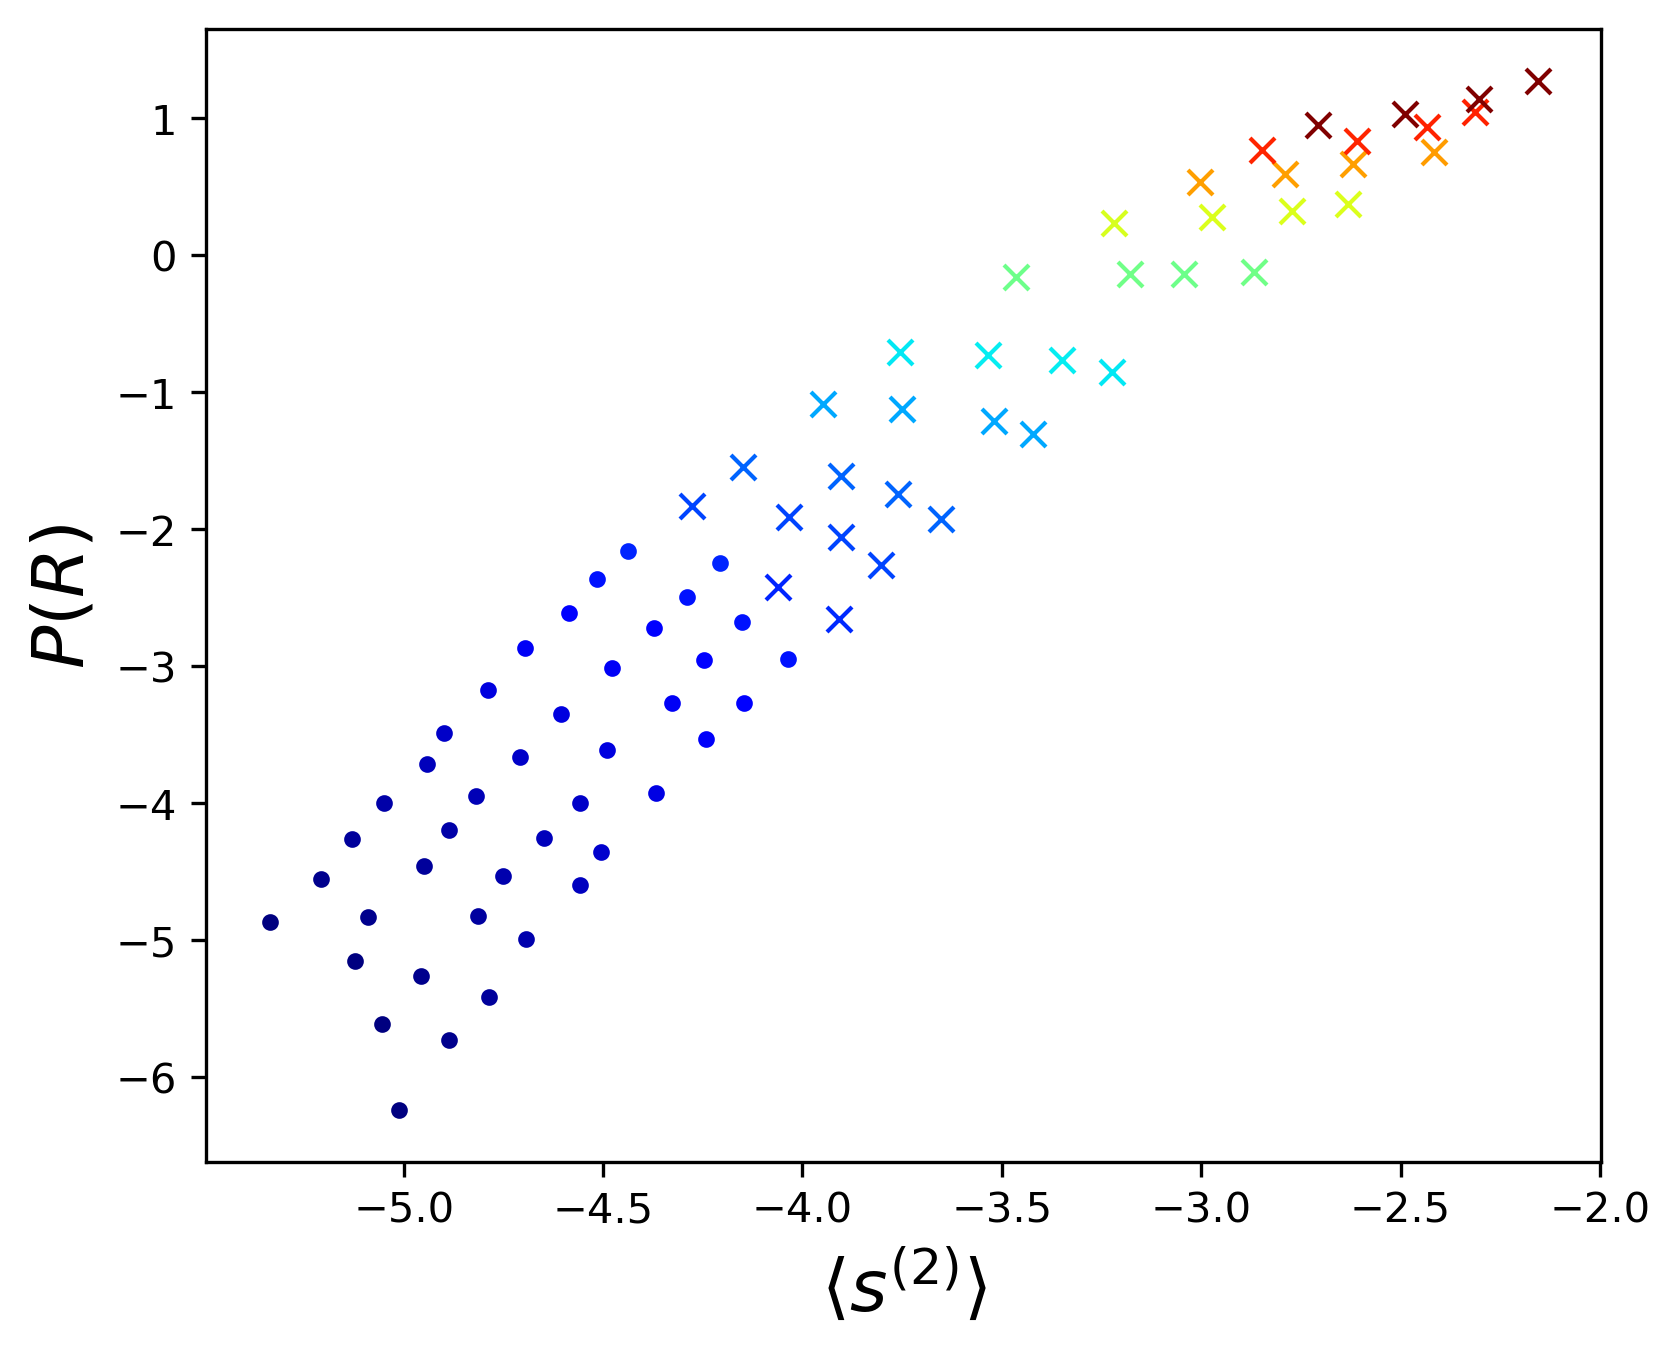

In [10]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

axs = [axs]

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-less3_delta-{delta}.pickle")

    # if delta != 0.4:
    #     continue

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    da_temps = 1/np.array(itemps)
    
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(T_a, da_temps)

    cmap = cm.jet
    norm = colors.Normalize(da_temps.min(), da_temps.max())

    for j in range(len(itemps)):
        real_temp = 1/itemps[j]
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        fits = np.array(fits)
        entropy = np.array(entropy)

        m = "."
        if real_temp > T_a:
            m = "x"

        Ns = np.array(data["data"][j]["Ns"])

        avg, std = weighted_avg_and_std(entropy, Ns)

        avg1, std1 = weighted_avg_and_std(fits[:,1] + fits[:,0]/real_temp, Ns)

        axs[0].plot(avg, avg1, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(real_temp)))
        # axs[1].plot(std, std1, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(real_temp)))

        # print(fits)
        

axs[0].set_xlabel(r"$\langle s^{(2)} \rangle$", size="xx-large")
axs[0].set_ylabel(r"$\langle P(R) \rangle$", size="xx-large")
# axs[1].set_xlabel(r"$T/T_A$", size="xx-large")
# axs[1].set_ylabel(r"$std(s^{(2)})$", size="xx-large")

0.716854578685853 [0.45 0.47 0.49 0.51 0.53 0.55 0.58 0.61 0.64 0.67 0.7  0.75 0.8  0.9
 1.   1.2  1.4  1.6  1.8  2.  ]
0.8798073052271798 [0.56 0.59 0.61 0.64 0.67 0.69 0.73 0.77 0.8  0.84 0.88 0.94 1.   1.13
 1.25 1.51 1.76 2.01 2.26 2.51]
1.1361484261693002 [0.73 0.76 0.8  0.83 0.86 0.89 0.94 0.99 1.04 1.09 1.14 1.22 1.3  1.46
 1.63 1.95 2.28 2.6  2.93 3.25]
1.5648003186178345 [0.99 1.03 1.08 1.12 1.16 1.21 1.27 1.34 1.41 1.47 1.54 1.65 1.76 1.98
 2.2  2.64 3.08 3.51 3.95 4.39]


/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(itemps, np.log(rearrang), 1)
/tmp/ipykernel_112499/2730804276.py:83: RuntimeW

2.23200724992835 [1.42 1.48 1.54 1.6  1.67 1.73 1.82 1.92 2.01 2.11 2.2  2.36 2.52 2.83
 3.15 3.77 4.4  5.03 5.66 6.29]


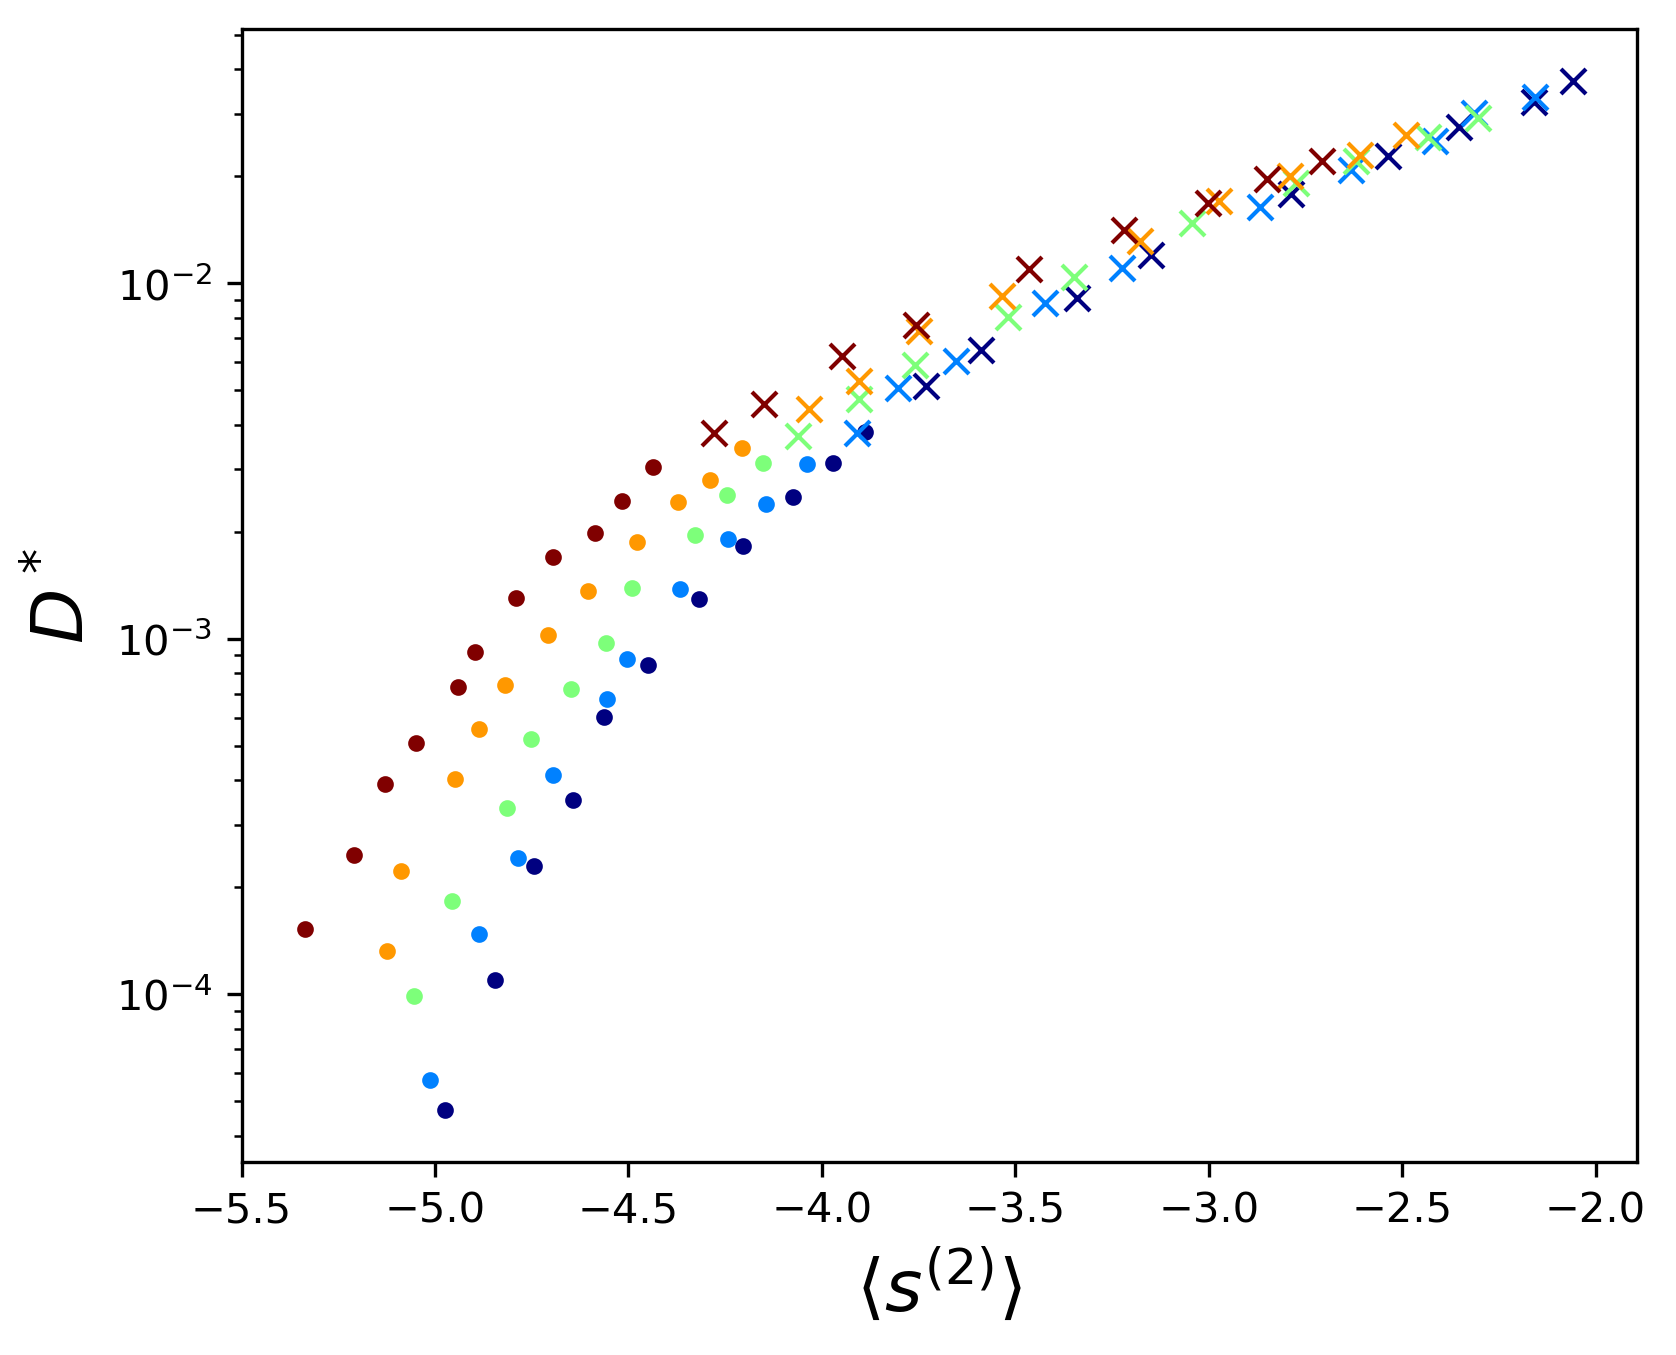

In [15]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

# plt.savefig("fig2.png", dpi=200)

fig, axs = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

axs = [axs]

diff_data = np.load(project.fn("dynamics/diffusion_coefficients.npz"), allow_pickle=True)

cmap = cm.jet
norm = colors.Normalize(0.0, 0.4)

for delta in [0.0, 0.1, 0.2, 0.3, 0.4]:
    file = project.fn(f"prob_rearrang/rdfs-bin-softness-less3_delta-{delta}.pickle")

    # if delta != 0.4:
    #     continue

    data = pickle.load(open(file, "rb"))

    itemps = data["inv_t"]
    da_temps = 1/np.array(itemps)

    
    in_cuts = data["data"][0]["cuts"]
    f_a = 0.8
    f_b = 0.2
    r = data["r_bc"]
    phi = data["phi"]

    sigma = (1 - delta/2**(1/6))

    d = diff_data[str(delta)]
    reduced_diffusion = np.array(d[()]["D"])*phi**(1/3)*np.sqrt(d[()]["inv_temp"])

    soft = pickle.load(open(project.fn(f"prob_rearrang/fit_softness_delta-{delta}.pickle"), "rb"))

    def reject_outliers(sr, iq_range=0.8):
        pcnt = (1 - iq_range) / 2
        qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
        iqr = qhigh - qlow
        return sr[ (sr - median).abs() <= iqr]

    data1 = []
    keys = list(soft["data"].keys())
    for i in range(len(keys)-1):
        v1 = soft["data"][keys[i]]["p"]
        for j in range(i+1, len(keys)):
            v2 = soft["data"][keys[j]]["p"]
            data1.append((v2[1] - v1[1]) / (v1[0] - v2[0]))
    T_a = 1/np.mean(reject_outliers(pd.Series(data1)).to_numpy())
    P_rs = []
    for i in range(len(keys)):
        v1 = soft["data"][keys[i]]["p"]
        P_rs.append(np.exp(v1[1] - v1[0]/T_a))
    P_r = np.log(np.mean(P_rs))
    print(T_a, da_temps)

    # cmap = cm.jet
    # norm = colors.Normalize(da_temps.min(), da_temps.max())

    for j in range(len(itemps)):
        real_temp = 1/itemps[j]
        fits = []
        entropy = []
        for i in range(len(data["cuts"])):
            rearrang = [d["rearrang"][i] for d in data["data"]]
            g_a = data["data"][j]["rdfs"][in_cuts[i]]["g_a"]
            g_b = data["data"][j]["rdfs"][in_cuts[i]]["g_b"]
            s = pair_excess_entropy_binary(g_a, g_b, f_a, f_b, r, phi)
            # s = pair_excess_entropy_binary(0.8*g_a + 0.2*g_b, r, phi)
            entropy.append(s)
            p = np.polyfit(itemps, np.log(rearrang), 1)

            fits.append(p)

        fits = np.array(fits)
        entropy = np.array(entropy)

        m = "."
        if real_temp > T_a:
            m = "x"

        Ns = np.array(data["data"][j]["Ns"])

        avg, std = weighted_avg_and_std(entropy, Ns)

        avg1, std1 = weighted_avg_and_std(fits[:,1] + fits[:,0]/real_temp, Ns)

        axs[0].plot(avg, reduced_diffusion[j], m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))
        # axs[1].plot(std, std1, m, linestyle="", label=f"{delta:.1f}", color=cmap(norm(delta)))

        # print(fits)
        

axs[0].set_xlabel(r"$\langle s^{(2)} \rangle$", size="xx-large")
axs[0].set_ylabel(r"$D^*$", size="xx-large")
axs[0].set_yscale('log')

In [48]:
sigma

0.6436405127438642